# **Algorithm Trading using Machine Learning Classification Models to Predict Price Movements and Backtesting Strategies**

Importing and Installing required Dependencies

In [ ]:
#Installing Pyflio (Library for Performance Analysis)
!pip install git+https://github.com/quantopian/pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-tm58l838
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio /tmp/pip-req-build-tm58l838
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.4 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75755 sha256=1470f28dd7b86f35af4caaf58459ce2f23a9215059422f192f722d6d1f04a621
  Stored in directory: /tmp/pip-ephem-wheel-cache-ykry0yuc/wheels/25/2f/dd/558b6be9405213c9f6fdb1c5a062028a4da70862268f4116e6
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39754 sha256=4f13af01a9d9f141555dbe50114565e079b0f2790dcfb5c0b30a23deecdd2cae
  Stored in d

In [ ]:
#Installing ta(for technical indicators), shap(for XAI), backtrader(for backtesting)
!pip install ta shap backtrader

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 10.6 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=aff958537e9d5c521fbe676282603ba7180e3e69331210387ec3b9a1b8c31844
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
# making the necessary imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
from scipy.stats import zscore
from sklearn import linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import datetime as dt
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings
import shap
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
'''# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# setting the style and ignoring warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')'''

"# this is to display images in notebook\n%matplotlib inline\n%config InlineBackend.figure_format = 'retina'\n# setting the style and ignoring warnings\nplt.style.use('seaborn-colorblind')\nwarnings.simplefilter(action='ignore', category=FutureWarning)\nwarnings.filterwarnings('ignore')"

### Data Gathering and Pre-Processing

In [ ]:
#Start and End Dates
start = dt.datetime(2018, 1, 1, 5, 30, 0)
end = dt.datetime(2022, 1, 31, 5,30,0)

In [ ]:
#Importing the 1H BTCUSDT Candlestick(Kline) data
KLine = pd.read_csv('btc_1h.csv')
KLine.head(2)


,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006


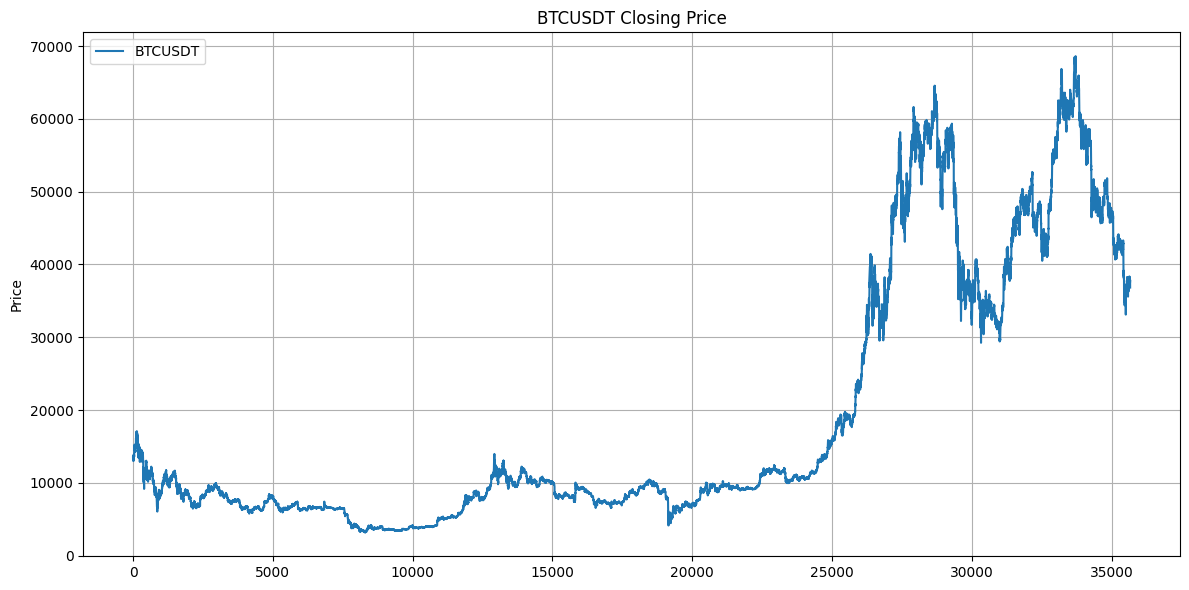

In [ ]:
#Ploting a Chart to show the Closing Prices
plt.figure(figsize = (12,6))
plt.plot(KLine['close'], label = f'BTCUSDT')
plt.title(f'BTCUSDT Closing Price')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Chart1_Closing_Prices.png', dpi=300)


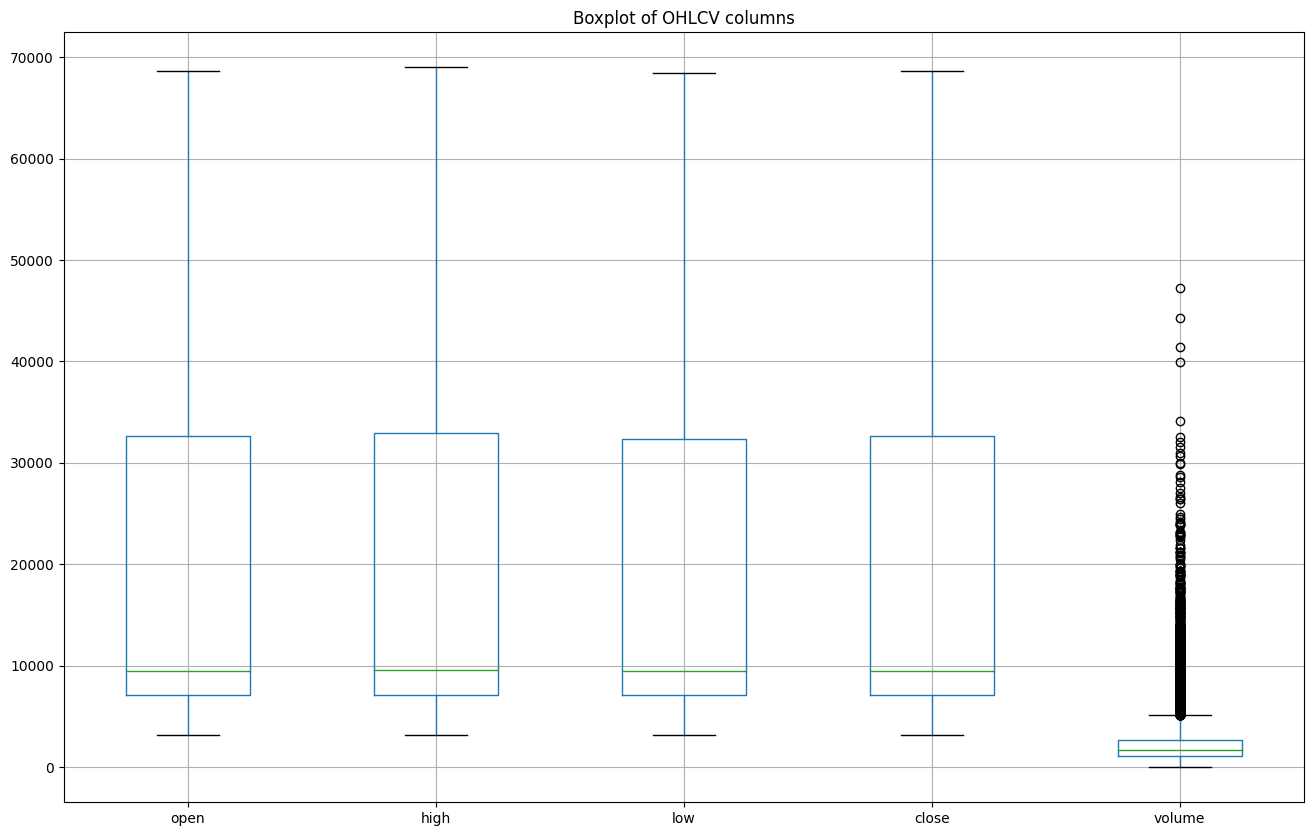

In [ ]:
#BoxPlot to show outliers in the data
KLine['datetime'] = pd.to_datetime(KLine['datetime'])
plt.figure(figsize=(16, 10))
KLine.boxplot(column=['open', 'high', 'low', 'close', 'volume'])
plt.title('Boxplot of OHLCV columns')
plt.show()

In [ ]:
#Calculating Z-Scores and filtering
numeric_cols = KLine.select_dtypes(include=[np.number]).columns #Numeric columns to avoid Datetime column
z_scores = KLine[numeric_cols].apply(zscore)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
KLine = KLine[filtered_entries]

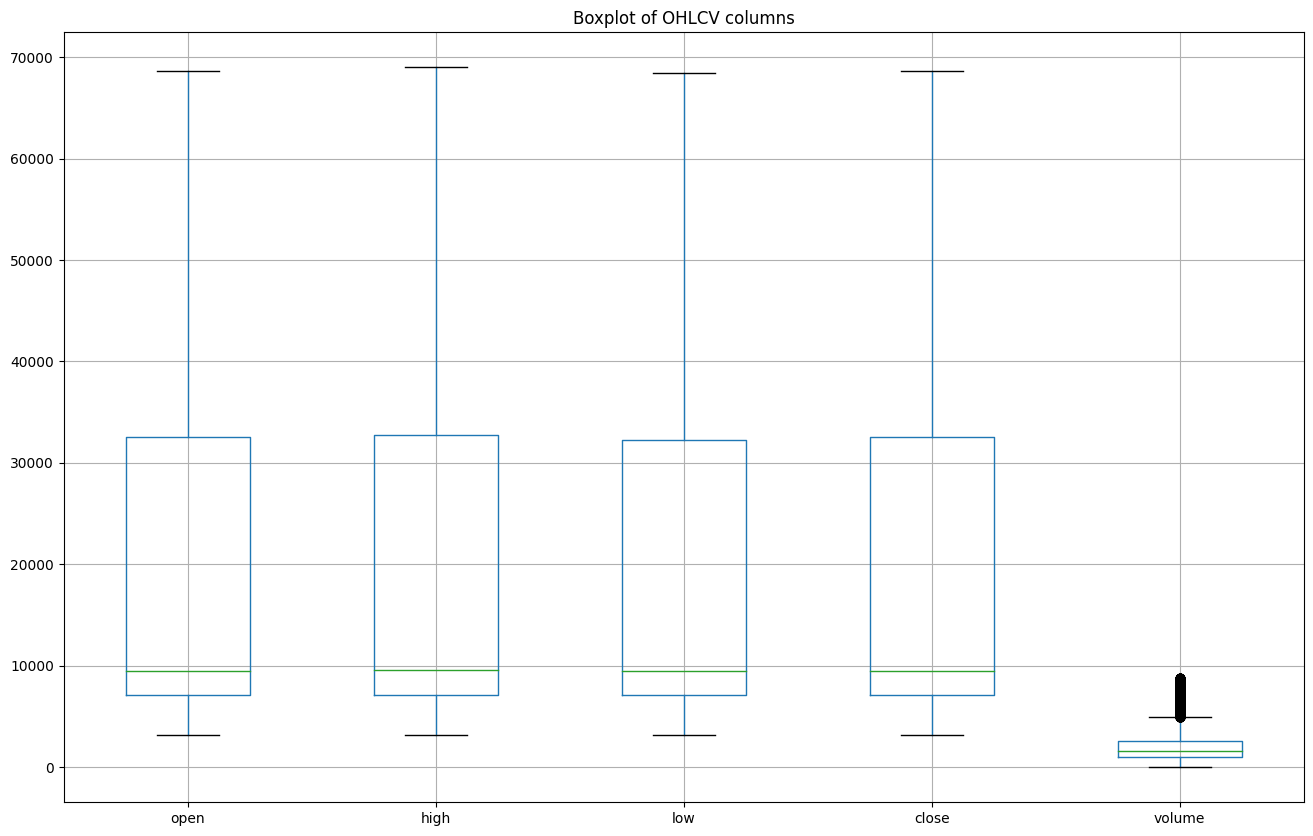

In [ ]:
#BoxPlotting the new data
plt.figure(figsize=(16, 10))
KLine.boxplot(column=['open', 'high', 'low', 'close', 'volume'])
plt.title('Boxplot of OHLCV columns')
plt.show()

### Feature Engineering

In [ ]:
# calculate daily log returns and market direction
KLine['returns'] = np.log(KLine['close'] / KLine['close'].shift(1)) #calculates the pct returns
KLine.dropna(inplace=True) #drop row with missing columns
KLine['direction'] = np.sign(KLine['returns']).astype(int) #assigns the changes a direction
KLine['target_direction'] = np.sign(KLine['returns']).astype(int).shift(-1)
KLine.head(10)

,datetime,open,high,low,close,volume,returns,direction,target_direction
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006,-0.024388,-1,1.0
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572,0.009582,1,1.0
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030,0.005972,1,1.0
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329,0.014141,1,-1.0
5,2018-01-01 10:30:00,13615.20,13699.00,13526.50,13558.99,404.229046,-0.003094,-1,1.0
6,2018-01-01 11:30:00,13539.00,13800.00,13510.00,13780.41,264.989684,0.016198,1,-1.0
7,2018-01-01 12:30:00,13780.00,13818.55,13555.02,13570.35,292.188777,-0.015361,-1,-1.0
8,2018-01-01 13:30:00,13569.98,13735.24,13400.00,13499.99,271.813553,-0.005198,-1,1.0
9,2018-01-01 14:30:00,13499.97,13670.00,13459.11,13616.99,213.095829,0.008629,1,-1.0
10,2018-01-01 15:30:00,13632.00,13657.92,13497.98,13570.01,169.512196,-0.003456,-1,-1.0


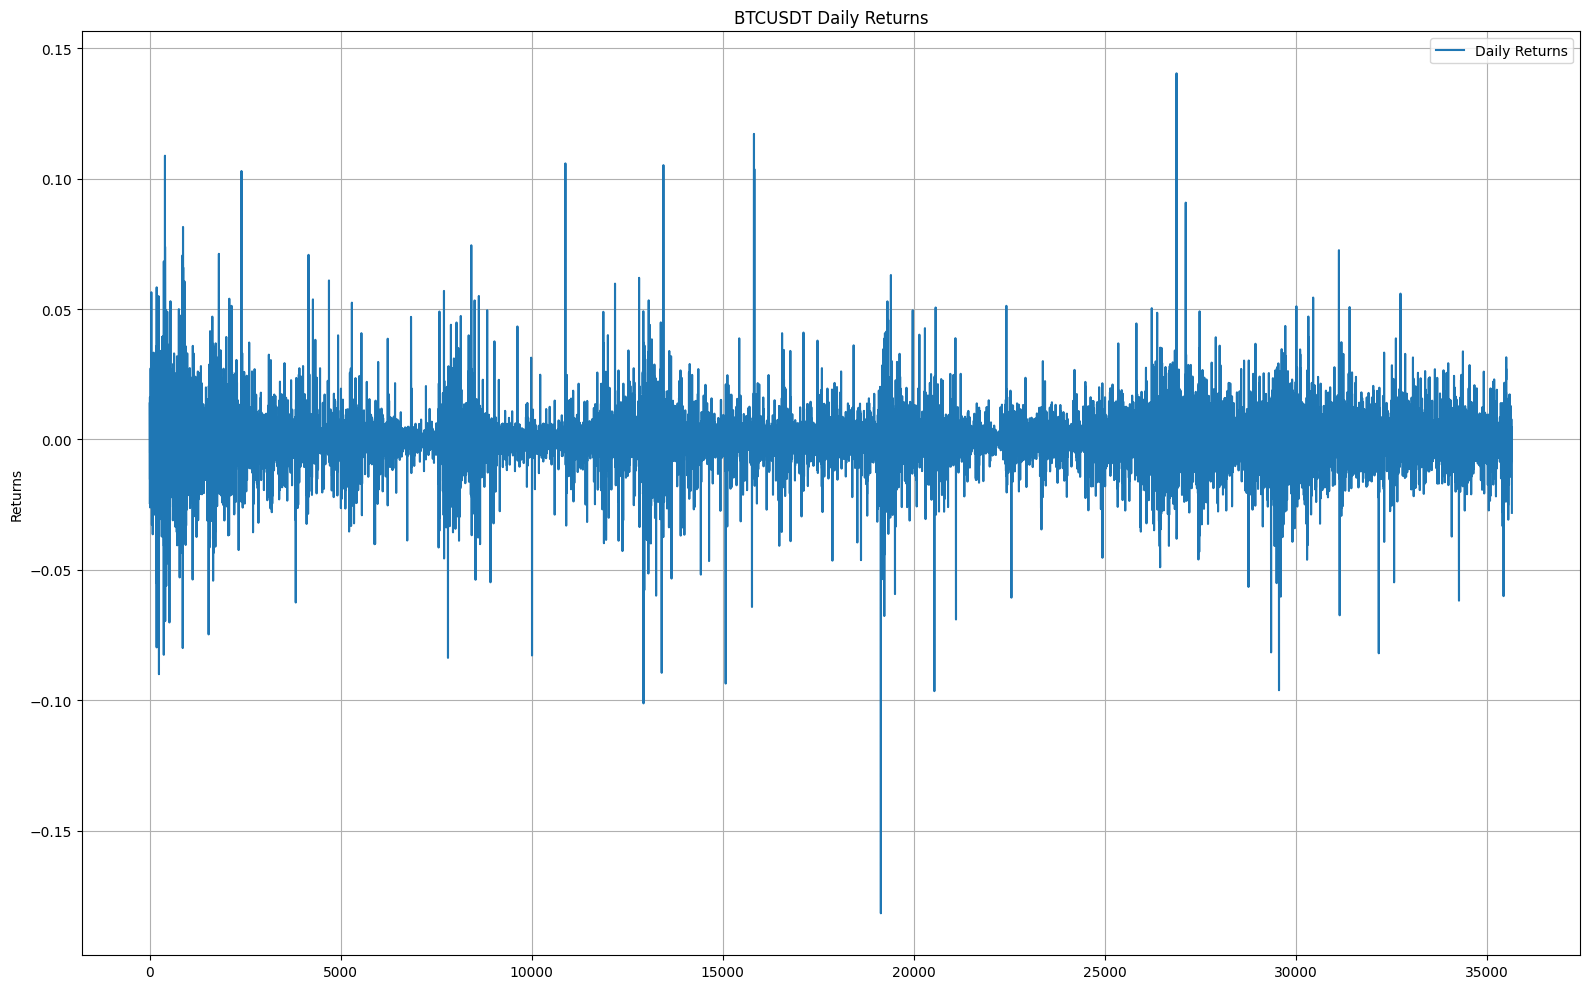

In [ ]:
#Plotting the Daily Returns
plt.figure(figsize=(16, 10))
plt.plot(KLine['returns'], label = 'Daily Returns')
plt.title(f'BTCUSDT Daily Returns')
plt.ylabel('Returns')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig('Chart2_Daily_Returns.png', dpi=300)

In [ ]:
#calculte the percent change in volume
KLine['pct_change_v'] = np.log(KLine['volume'] / KLine['volume'].shift(1))
KLine.dropna(inplace=True) #dropping rows with None values
KLine.head(3)

divide by zero encountered in log


,datetime,open,high,low,close,volume,returns,direction,target_direction,pct_change_v
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572,0.009582,1,1.0,0.111754
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030,0.005972,1,1.0,-0.021146
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329,0.014141,1,-1.0,-0.209145


In [ ]:
#The number of lags we introduce in the data
lags = [1, 2, 4, 5, 8 ]
v_lags =[1]

In [ ]:
# compute lagged log returns on the close price
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    KLine[col] = KLine['returns'].shift(lag)
    cols.append(col)

KLine.dropna(inplace=True)
KLine.head(2)

,datetime,open,high,low,close,volume,returns,direction,target_direction,pct_change_v,rtn_lag1,rtn_lag2,rtn_lag4,rtn_lag5,rtn_lag8
10,2018-01-01 15:30:00,13632.0,13657.92,13497.98,13570.01,169.512196,-0.003456,-1,-1.0,-0.228817,0.008629,-0.005198,0.016198,-0.003094,0.009582
11,2018-01-01 16:30:00,13573.0,13589.89,13001.13,13220.56,665.334353,-0.026089,-1,-1.0,1.367365,-0.003456,0.008629,-0.015361,0.016198,0.005972


In [ ]:
vols = []
for lag in v_lags:
    vol = f'v_lag{lag}'
    KLine[vol] = KLine['pct_change_v'].shift(lag)
    vols.append(vol)

KLine.dropna(inplace=True)
KLine.head(2)

,datetime,open,high,low,close,volume,returns,direction,target_direction,pct_change_v,rtn_lag1,rtn_lag2,rtn_lag4,rtn_lag5,rtn_lag8,v_lag1
11,2018-01-01 16:30:00,13573.00,13589.89,13001.13,13220.56,665.334353,-0.026089,-1,-1.0,1.367365,-0.003456,0.008629,-0.015361,0.016198,0.005972,-0.228817
12,2018-01-01 17:30:00,13220.56,13300.00,13056.23,13172.42,260.492708,-0.003648,-1,-1.0,-0.937715,-0.026089,-0.003456,-0.005198,-0.015361,0.014141,1.367365


In [ ]:
# A Function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)

In [ ]:
# use the function
create_bins(KLine)
KLine[cols+cols_bin].head(2)

,rtn_lag1,rtn_lag2,rtn_lag4,rtn_lag5,rtn_lag8,rtn_lag1_bin,rtn_lag2_bin,rtn_lag4_bin,rtn_lag5_bin,rtn_lag8_bin
11,-0.003456,0.008629,-0.015361,0.016198,0.005972,0,1,0,1,1
12,-0.026089,-0.003456,-0.005198,-0.015361,0.014141,0,0,0,0,1


In [ ]:
# A Function to transform the lag volumes to binary values (0,+1)
def create_bins_v(data, bins=[0]):
    global vols_bin
    vols_bin = []
    for vol in vols:
        vol_bin = vol + '_bin'
        data[vol_bin] = np.digitize(data[vol], bins=bins)
        vols_bin.append(vol_bin)

In [ ]:
# use the function
create_bins_v(KLine)
KLine[vols+vols_bin].head(2)

,v_lag1,v_lag1_bin
11,-0.228817,0
12,1.367365,1


In [ ]:
cols_bin = cols_bin + vols_bin
print(KLine.head(2))

              datetime      open      high       low     close      volume  \
11 2018-01-01 16:30:00  13573.00  13589.89  13001.13  13220.56  665.334353   
12 2018-01-01 17:30:00  13220.56  13300.00  13056.23  13172.42  260.492708   

     returns  direction  target_direction  pct_change_v  ...  rtn_lag4  \
11 -0.026089         -1              -1.0      1.367365  ... -0.015361   
12 -0.003648         -1              -1.0     -0.937715  ... -0.005198   

    rtn_lag5  rtn_lag8    v_lag1  rtn_lag1_bin  rtn_lag2_bin  rtn_lag4_bin  \
11  0.016198  0.005972 -0.228817             0             1             0   
12 -0.015361  0.014141  1.367365             0             0             0   

    rtn_lag5_bin  rtn_lag8_bin  v_lag1_bin  
11             1             1           0  
12             0             1           1  

[2 rows x 22 columns]


In [ ]:

# Print the list showing all our features
print(cols_bin)
KLine.dropna(inplace=True)
print(KLine)


['rtn_lag1_bin', 'rtn_lag2_bin', 'rtn_lag4_bin', 'rtn_lag5_bin', 'rtn_lag8_bin', 'v_lag1_bin']
                 datetime      open      high       low     close  \
11    2018-01-01 16:30:00  13573.00  13589.89  13001.13  13220.56   
12    2018-01-01 17:30:00  13220.56  13300.00  13056.23  13172.42   
13    2018-01-01 18:30:00  13150.05  13200.41  12815.70  13017.00   
14    2018-01-01 19:30:00  12999.71  13245.00  12750.00  13211.39   
15    2018-01-01 20:30:00  13211.39  13330.00  13120.38  13247.00   
...                   ...       ...       ...       ...       ...   
35658 2022-01-31 00:30:00  37820.96  37827.14  37442.52  37512.37   
35659 2022-01-31 01:30:00  37512.37  37740.00  37351.63  37684.45   
35660 2022-01-31 02:30:00  37684.45  37762.60  37492.25  37729.00   
35661 2022-01-31 03:30:00  37729.00  37855.54  37625.41  37785.78   
35662 2022-01-31 04:30:00  37785.78  38230.00  37778.46  37881.76   

            volume   returns  direction  target_direction  pct_change_v  ...

training and analysing only RF model because it performs best

In [ ]:
np.shape(KLine[cols_bin])

(35023, 6)

### Build and Apply  Machine Learning Algorithms

We selected LR, Gaussian Naive Bayes, SVMs, Random Forest, and MLP approaches to predict the market direction.

In [ ]:
# create a dictionary of all selected models
models = {
    #'log_reg': linear_model.LogisticRegression(),
    #'gauss_nb': GaussianNB(),
    #'svm': SVC(),
    'random_forest': RandomForestClassifier(max_depth=10, n_estimators=200),#the parameters suited the best
    #'MLP' : MLPClassifier(max_iter=500),
}

In [ ]:
# function that fits all models.
def fit_models(data):
    mfit = {model: models[model].fit(data[cols_bin], data['target_direction']) for model in models.keys()}

In [ ]:
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [ ]:
# function to evaluate all trading strategies
def evaluate_strats(data):
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')

In [ ]:
# fit the models
fit_models(KLine)

In [ ]:
# derives all position values
derive_positions(KLine)

In [ ]:
# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(KLine)

In [ ]:
#here we test accuracy, precision, recall, F1 score and confusion matrix


model_rf=RandomForestClassifier(max_depth=10, n_estimators=200)

model_rf.fit(KLine[cols_bin], KLine['target_direction'])

y_pred =  model_rf.predict(KLine[cols_bin])
y_test = KLine["target_direction"]


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.5307
Precision: 0.5299
Recall: 0.5307
F1 Score: 0.5294
Confusion Matrix:
[[ 8188     0  8955]
 [    3     0     9]
 [ 7469     0 10399]]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
# calculate total return of each strategy
print('\nTotal Returns:')
print(KLine[strategy_rtn].sum().apply(np.exp))



Total Returns:
returns                    2.791579
strategy_random_forest    38.268024
dtype: float64


In [ ]:
print(KLine)

                 datetime      open      high       low     close  \
11    2018-01-01 16:30:00  13573.00  13589.89  13001.13  13220.56   
12    2018-01-01 17:30:00  13220.56  13300.00  13056.23  13172.42   
13    2018-01-01 18:30:00  13150.05  13200.41  12815.70  13017.00   
14    2018-01-01 19:30:00  12999.71  13245.00  12750.00  13211.39   
15    2018-01-01 20:30:00  13211.39  13330.00  13120.38  13247.00   
...                   ...       ...       ...       ...       ...   
35658 2022-01-31 00:30:00  37820.96  37827.14  37442.52  37512.37   
35659 2022-01-31 01:30:00  37512.37  37740.00  37351.63  37684.45   
35660 2022-01-31 02:30:00  37684.45  37762.60  37492.25  37729.00   
35661 2022-01-31 03:30:00  37729.00  37855.54  37625.41  37785.78   
35662 2022-01-31 04:30:00  37785.78  38230.00  37778.46  37881.76   

            volume   returns  direction  target_direction  pct_change_v  ...  \
11      665.334353 -0.026089         -1              -1.0      1.367365  ...   
12      260

###SHAP (XAI)

In [ ]:
#evaluation of our prediction using  SHAP
model_rf = models["random_forest"]
ex = shap.KernelExplainer(model_rf.predict, shap.sample(KLine[cols_bin],10))

  0%|          | 0/200 [00:00<?, ?it/s]

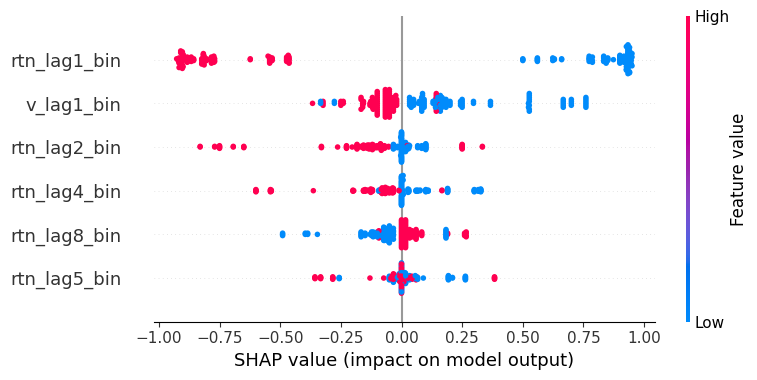

In [ ]:
shap.initjs()
shap_values = ex.shap_values(KLine[cols_bin].iloc[:200])
shap.summary_plot(shap_values, KLine[cols_bin].iloc[:200])

In [ ]:
np.shape(shap_values)

(200, 6)

In [ ]:
shap.initjs()
shap_values = ex.shap_values(KLine[cols_bin].iloc[10,:])
shap.force_plot(ex.expected_value, shap_values,KLine[cols_bin].iloc[10,:],matplotlib =matplotlib)

NameError: name 'matplotlib' is not defined

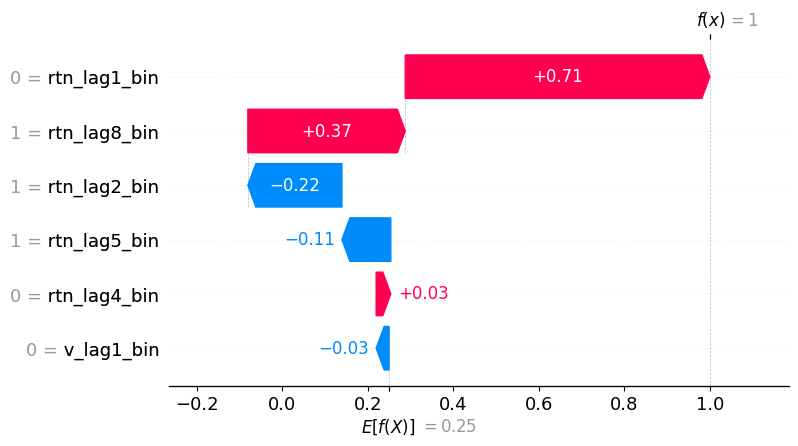

In [ ]:
# Create a SHAP Explanation object for the corresponding instance
shap.initjs()
shap_explanation = shap.Explainer(model_rf.predict,KLine[cols_bin].iloc[:72])
shap_val = shap_explanation(KLine[cols_bin].iloc[:24])
# Waterfall Plot
shap.plots.waterfall(shap_val[0])

In [ ]:
shap.plots.bar(shap_val)

In [ ]:
shap.plots.beeswarm(shap_val)

### Backtesting of Selected Strategy using Backtrader Library

In [ ]:
# read the data from the file again
prices =  pd.read_csv('btc_1h.csv')
prices.head(2)

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006


In [ ]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = KLine['strategy_random_forest']
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_random_forest':'predicted'}, inplace=True)

In [ ]:
predictions = prices.join(predictions, how='left').dropna()
prices= predictions

In [ ]:
prices['datetime'] = pd.to_datetime(prices['datetime'])
prices = prices.set_index("datetime")
prices.head()

,open,high,low,close,volume,predicted
datetime,,,,,,
2018-01-01 16:30:00,13573.00,13589.89,13001.13,13220.56,665.334353,-0.026089
2018-01-01 17:30:00,13220.56,13300.00,13056.23,13172.42,260.492708,-0.003648
2018-01-01 18:30:00,13150.05,13200.41,12815.70,13017.00,451.901126,-0.011869
2018-01-01 19:30:00,12999.71,13245.00,12750.00,13211.39,692.467362,0.014823
2018-01-01 20:30:00,13211.39,13330.00,13120.38,13247.00,427.071957,-0.002692


In [ ]:
prices.head(20)

,open,high,low,close,volume,predicted
datetime,,,,,,
2018-01-01 16:30:00,13573.00,13589.89,13001.13,13220.56,665.334353,-0.026089
2018-01-01 17:30:00,13220.56,13300.00,13056.23,13172.42,260.492708,-0.003648
2018-01-01 18:30:00,13150.05,13200.41,12815.70,13017.00,451.901126,-0.011869
2018-01-01 19:30:00,12999.71,13245.00,12750.00,13211.39,692.467362,0.014823
2018-01-01 20:30:00,13211.39,13330.00,13120.38,13247.00,427.071957,-0.002692
2018-01-01 21:30:00,13247.00,13247.08,12966.42,13018.00,367.393566,-0.017438
2018-01-01 22:30:00,13018.00,13198.98,13000.00,13022.00,228.572028,0.000307
2018-01-01 23:30:00,13007.87,13256.28,12940.00,13135.00,244.366755,-0.008640
2018-01-02 00:30:00,13135.00,13290.65,13106.61,13240.37,252.004885,-0.007990


In [ ]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

Strategy & Risk Management:
1.	Buy when the predicted value is +ve and sell (only if stock is in possession) when the predicted value is -ve(immediately mitigating risk and restricting possible lossy trades to the next frequency).
2.	Using a percent sizer buy stakes as a percent of available capital(buying more when more cash is available and less when less cash is on hand)
3.	Trailing Stop Loss is Also used.

In [ ]:
# extension of PandasData to define the columns we will provide
class SignalData(PandasData):

    cols = ['predicted'] + OHLCV

    lines = tuple(cols)

    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [ ]:
# define backtesting strategy class that helps us trade
class RFStrategy(bt.Strategy):
    params = dict(
    )
    def __init__(self):
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close

        self.order = None
        self.price = None
        self.comm = None
        self.short = False
    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
        # report failed order
        elif order.status in [order.Canceled, order.Margin,
                              order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price,
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0.019:
                self.buy()
                self.log(f'BUY CREATED --- Size: {self.position.size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
            if self.data_predicted < -0.019:
              self.sell()
              self.log(f'SHORT CREATED --- Size: {self.position.size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
              self.short = True
        else:
          if self.short == True:
            if self.data_predicted > 0.005:
              self.close()
              self.log('SHORT CLOSED')
              self.short = False
          else:
            if self.data_predicted < -0.005:
             self.sell(size=self.position.size)


In [ ]:
import numpy as np

# Initialize the global array
global_signal = np.array([])

class RFStrategys(bt.Strategy):
    params = dict(
    )
    def __init__(self):
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close

        self.order = None
        self.price = None
        self.comm = None
        self.short = False
    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    def notify_order(self, order):
        global global_signal
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
                global_signal = np.append(global_signal, 1)  # Append 1 for buy
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
                global_signal = np.append(global_signal, -1)  # Append -1 for sell
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')
        self.order = None
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
    def next_open(self):
        global global_signal
        if not self.position:
            if self.data_predicted > 0.019:
                self.buy()
                self.log(f'BUY CREATED --- Size: {self.position.size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
            elif self.data_predicted < -0.019:
                self.sell()
                self.log(f'SHORT CREATED --- Size: {self.position.size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.short = True
        else:
            global_signal = np.append(global_signal, 0)  # Append 0 for hold
            if self.short == True:
                if self.data_predicted > 0.005:
                    self.close()
                    self.log('SHORT CLOSED')
                    self.short = False
            else:
                if self.data_predicted < -0.005:
                    self.sell(size=self.position.size)


In [ ]:
# This is a Strategy that incorporates a configurable,Trailing stop loss. possibly in a
#real life scenario, it can be implemented as required.

'''class RFStrategy(bt.Strategy):
    params = dict(
        stop_loss=0.02,  # 2% stop loss
    )

    def __init__(self):
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close

        self.order = None
        self.price = None
        self.comm = None
        self.stop_price = None

    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
                self.stop_price = self.price * (1.0 - self.params.stop_loss)
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                self.buy()
                self.log(f'BUY CREATED --- Size: {self.position.size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')

        else:
            if self.data_predicted < 0 or self.data_close[0] < self.stop_price:
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)
'''

"class RFStrategy(bt.Strategy):\n    params = dict(\n        stop_loss=0.02,  # 2% stop loss\n    )\n\n    def __init__(self):\n        self.data_predicted = self.datas[0].predicted\n        self.data_open = self.datas[0].open\n        self.data_close = self.datas[0].close\n\n        self.order = None\n        self.price = None\n        self.comm = None\n        self.stop_price = None\n\n    def log(self, txt):\n        dt = self.datas[0].datetime.date(0).isoformat()\n        print(f'{dt}, {txt}')\n\n    def notify_order(self, order):\n        if order.status in [order.Submitted, order.Accepted]:\n            return\n\n        if order.status in [order.Completed]:\n            if order.isbuy():\n                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')\n                self.price = order.executed.price\n                self.comm = order.executed.comm\n                self.stop_price = self.pr

In [ ]:
class Benchmark_Return(bt.Strategy):
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def nextstart(self):
        # Buy all the available cash
        self.order_target_value(target=self.broker.get_cash())

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

In [ ]:
class AvgTrade(bt.Analyzer):
    def __init__(self):
        self.winning_trades = []
        self.losing_trades = []

    def notify_trade(self, trade):
        if trade.isclosed:
            if trade.pnl > 0:
                self.winning_trades.append(trade.pnl)
            else:
                self.losing_trades.append(trade.pnl)
    def stop(self):
        avg_winning_trade = sum(self.winning_trades) / len(self.winning_trades) if self.winning_trades else 0
        avg_losing_trade = sum(self.losing_trades) / len(self.losing_trades) if self.losing_trades else 0

        print(f'Average Winning Trade: {avg_winning_trade}')
        print(f'Average Losing Trade: {avg_losing_trade}')

In [ ]:
class Required_Stats(bt.Analyzer):
    params = (
        ('printlog', False),
    )

    def __init__(self):
        self.total_trades = 0
        self.winning_trades = 0
        self.total_net_profit = 0.0
        self.total_gross_profit = 0.0
        self.total_gross_loss = 0.0
        self.largest_winning_trade = 0.0
        self.largest_losing_trade = 0.0
        self.total_holding_duration = 0
        self.total_drawdown = 0.0
        self.running_trade_duration = 0
        self.running_trade_drawdown = 0.0
        self.last_trade_end_value = 0.0
        self.total_winning_trade = 0
        self.total_losing_trade = 0
        self.average_winning_trade = 0.0
        self.average_losing_trade = 0.0
        self.risk_reward_ratio = 0.0

    def start(self):
        self.starting_cash = self.strategy.broker.startingcash
        self.max_portfolio_value = self.starting_cash

    def stop(self):
        self.ending_cash = self.strategy.broker.getvalue()
        self.total_net_profit = self.ending_cash - self.starting_cash

        if self.total_trades > 0:
            win_rate = (self.winning_trades / self.total_trades) * 100
            average_holding_duration = self.total_holding_duration / self.total_trades
            print(f"Total Trades: {self.total_trades}")
            print(f"Total Gross Profit: {self.total_gross_profit:.2f}")
            print(f"Total Gross Loss: {self.total_gross_loss:.2f}")
            print(f"Largest Winning Trade: {self.largest_winning_trade:.2f}")
            print(f"Largest Losing Trade: {self.largest_losing_trade:.2f}")
            print(f"Average Winning Trade: {self.average_winning_trade:.2f}")
            print(f"Average Losing Trade: {self.average_losing_trade:.2f}")
            print(f"Risk-Reward Ratio: {self.risk_reward_ratio:.2f}")
            print(f"Average Holding Duration: {average_holding_duration:.2f} periods")
            print(f"Net Profit: {self.total_net_profit:.2f}")
            print(f"Win Rate: {win_rate:.2f}%")

    def notify_trade(self, trade):
        if trade.isclosed:
            self.total_trades += 1
            pnl = trade.pnl
            if pnl > 0:
                self.winning_trades += 1
                self.total_winning_trade += 1
                self.total_gross_profit += pnl
                if pnl > self.largest_winning_trade:
                    self.largest_winning_trade = pnl
            else:
                self.total_losing_trade += 1
                self.total_gross_loss += abs(pnl)
                if abs(pnl) > self.largest_losing_trade:
                    self.largest_losing_trade = abs(pnl)

            self.total_holding_duration += trade.barlen
            self.total_drawdown += self.running_trade_drawdown
            self.running_trade_duration = 0
            self.running_trade_drawdown = 0.0

            if self.total_winning_trade > 0:
                self.average_winning_trade = self.total_gross_profit / self.total_winning_trade
            if self.total_losing_trade > 0:
                self.average_losing_trade = self.total_gross_loss / self.total_losing_trade
            if self.average_losing_trade != 0:
                self.risk_reward_ratio = self.average_winning_trade / self.average_losing_trade

    def notify_data(self, data, status, *args, **kwargs):
        if status == data.LIVE and self.last_trade_end_value == 0:
            self.last_trade_end_value = self.strategy.broker.getvalue()
        elif status == data.LIVE and self.last_trade_end_value != 0:
            current_value = self.strategy.broker.getvalue()
            self.running_trade_duration += 1
            self.running_trade_drawdown = max(self.max_portfolio_value - current_value, self.running_trade_drawdown)
            self.max_portfolio_value = max(self.max_portfolio_value, current_value)
        elif status == data.DONE:
            self.last_trade_end_value = 0


In [ ]:
# instantiate SignalData class

data = SignalData(dataname=prices, datetime= None)

In [ ]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(Benchmark_Return)
cerebro.adddata(data)
cerebro.broker.setcash(1000000.0)
cerebro.broker.setcommission(commission=0.00075)
cerebro.addanalyzer(AvgTrade, _name='trade_analyzer')
cerebro.addanalyzer(Required_Stats, _name='cta')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [ ]:
# run the backtest, and get the Benchmark Returns
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
ROI:        184.88%
Average Winning Trade: 0
Average Losing Trade: 0
Final Portfolio Value: 2848846.34


In [ ]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(RFStrategys)
cerebro.adddata(data)
cerebro.broker.setcash(1000000.0)
cerebro.broker.setcommission(commission=0.00075)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 31)
cerebro.addanalyzer(AvgTrade, _name='trade_analyzer')
cerebro.addanalyzer(Required_Stats, _name='cta')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [ ]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-01-02, BUY CREATED --- Size: 0, Cash: 1000000.00, Open: 13382.16, Close: 13750.01
2018-01-02, BUY EXECUTED --- Price: 13382.16, Cost: 301706.66,Commission: 226.28
2018-01-02, SELL EXECUTED --- Price: 13611.93, Cost: 301706.66,Commission: 230.17
2018-01-02, OPERATION RESULT --- Gross: 5180.27, Net: 4723.82
2018-01-02, BUY CREATED --- Size: 0.0, Cash: 1004723.82, Open: 13489.04, Close: 13864.98
2018-01-02, BUY EXECUTED --- Price: 13489.04, Cost: 303019.23,Commission: 227.26
2018-01-03, SELL EXECUTED --- Price: 14576.87, Cost: 303019.23,Commission: 245.59
2018-01-03, OPERATION RESULT --- Gross: 24437.13, Net: 23964.27
2018-01-03, SHORT CREATED --- Size: 0.0, Cash: 1028688.09, Open: 15002.59, Close: 14519.99
2018-01-03, SELL EXECUTED --- Price: 15002.59, Cost: -329492.35,Commission: 247.12
2018-01-03, SHORT CLOSED
2018-01-03, BUY EXECUTED --- Price: 14455.55, Cost: -329492.35,Commission: 238.11
2018-01-03, OPERATION RESULT --- Gross: 12014.29, Net:

##Results and all Required Test Statistcs






In [ ]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
jj = pyfoliozer.get_analysis()

#These represent all the requried stats
returns.name = 'Strategy'
yt_1 = strat.analyzers.getbyname('trade_analyzer')
yt_2 = strat.analyzers.getbyname('cta')
ytx = yt_2.stop()
yts = yt_1.stop()




Total Trades: 968
Total Gross Profit: 8229984.76
Total Gross Loss: 6342228.80
Largest Winning Trade: 130389.54
Largest Losing Trade: 67345.59
Average Winning Trade: 15156.51
Average Losing Trade: 14922.89
Risk-Reward Ratio: 1.02
Average Holding Duration: 4.68 periods
Net Profit: 1076307.21
Win Rate: 56.10%
Average Winning Trade: 15156.509678157689
Average Losing Trade: -14922.891283544326


In [ ]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
iteritems is deprecated and will be removed in a future version. Use .items instead.


Start date,2018-01-01
End date,2022-01-31
Total months,71
,Backtest
Annual return,13.133%
Cumulative returns,107.631%
Annual volatility,13.426%
Sharpe ratio,0.99
Calmar ratio,0.99
Stability,0.62
Max drawdown,-13.264%


In [ ]:
global_signal
sub = pd.DataFrame(global_signal, columns=['signal'])
sub1 = pd.read_csv('btc_1h.csv')
sub1 = sub.join(sub1, how='left')
sub1.head(15)



,signal,datetime,open,high,low,close,volume
0,1.0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
1,0.0,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006
2,0.0,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572
3,-1.0,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030
4,1.0,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329
5,0.0,2018-01-01 10:30:00,13615.20,13699.00,13526.50,13558.99,404.229046
6,0.0,2018-01-01 11:30:00,13539.00,13800.00,13510.00,13780.41,264.989684
7,0.0,2018-01-01 12:30:00,13780.00,13818.55,13555.02,13570.35,292.188777
8,0.0,2018-01-01 13:30:00,13569.98,13735.24,13400.00,13499.99,271.813553
9,0.0,2018-01-01 14:30:00,13499.97,13670.00,13459.11,13616.99,213.095829


In [ ]:
sub1.to_csv('sub1.csv', index=False)


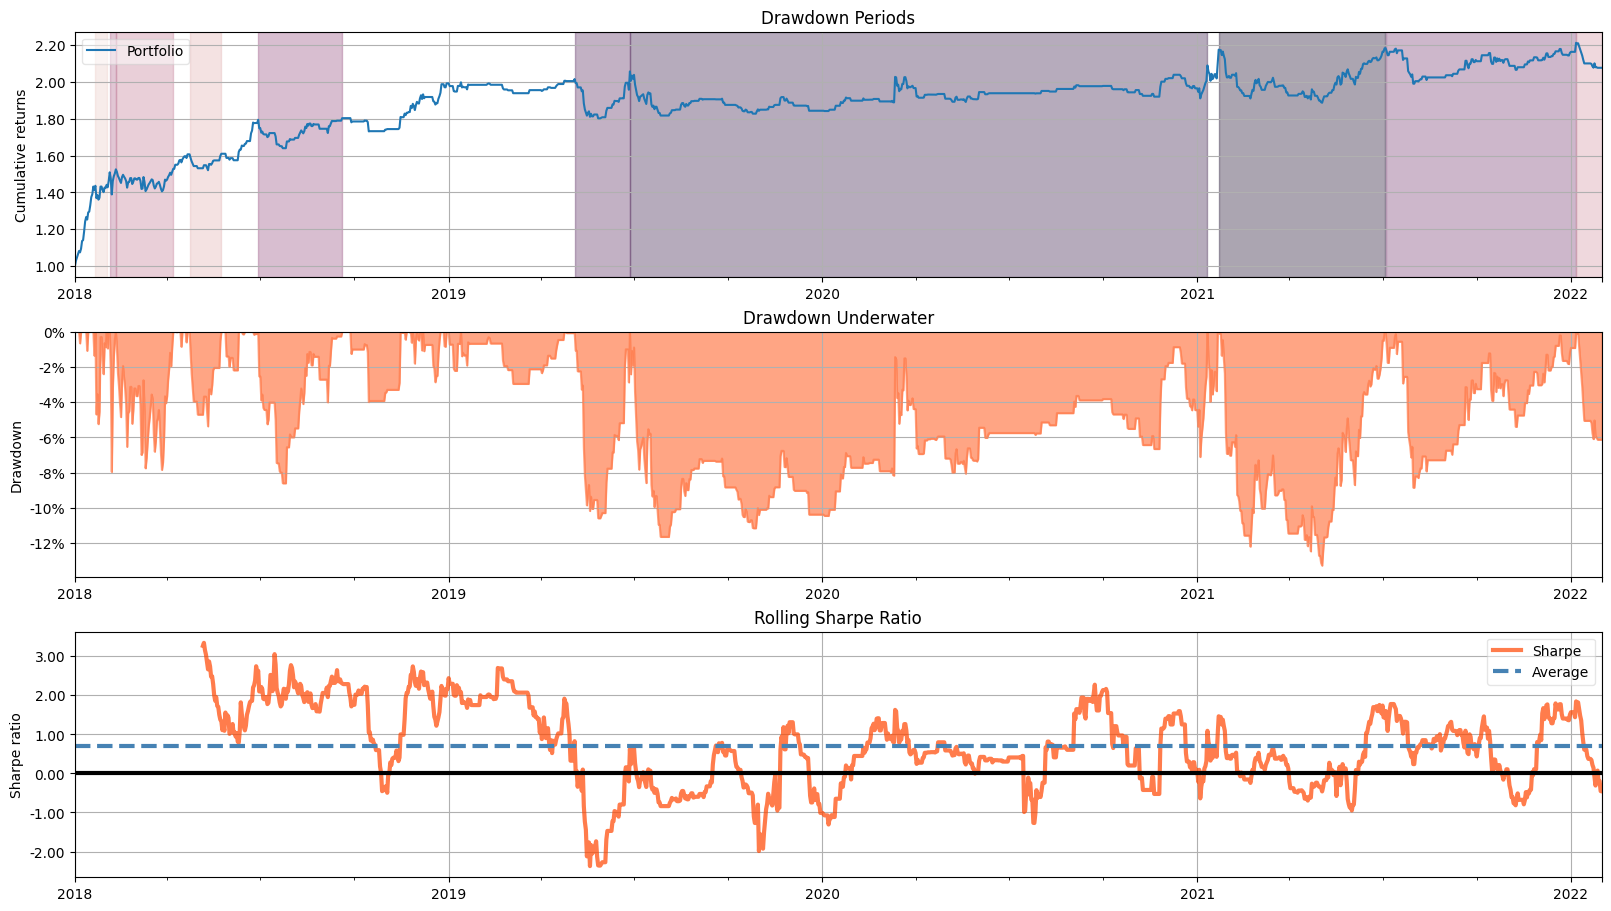

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plottin drawdown periods, underwater and rolling sharpe
fig, ax = plt.subplots(nrows=3, figsize=(16, 9), constrained_layout=True)
axes = ax.flatten()

pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].set_title('Drawdown Periods')
axes[0].grid(True)

pf.plot_drawdown_underwater(returns=returns, ax=axes[1])
axes[1].set_title('Drawdown Underwater')
axes[1].grid(True)

pf.plot_rolling_sharpe(returns=returns, ax=axes[2])
axes[2].set_title('Rolling Sharpe Ratio')
axes[2].grid(True)

plt.show()


plt.savefig('Chart3_Perf_Analysis_1.png', dpi=300)

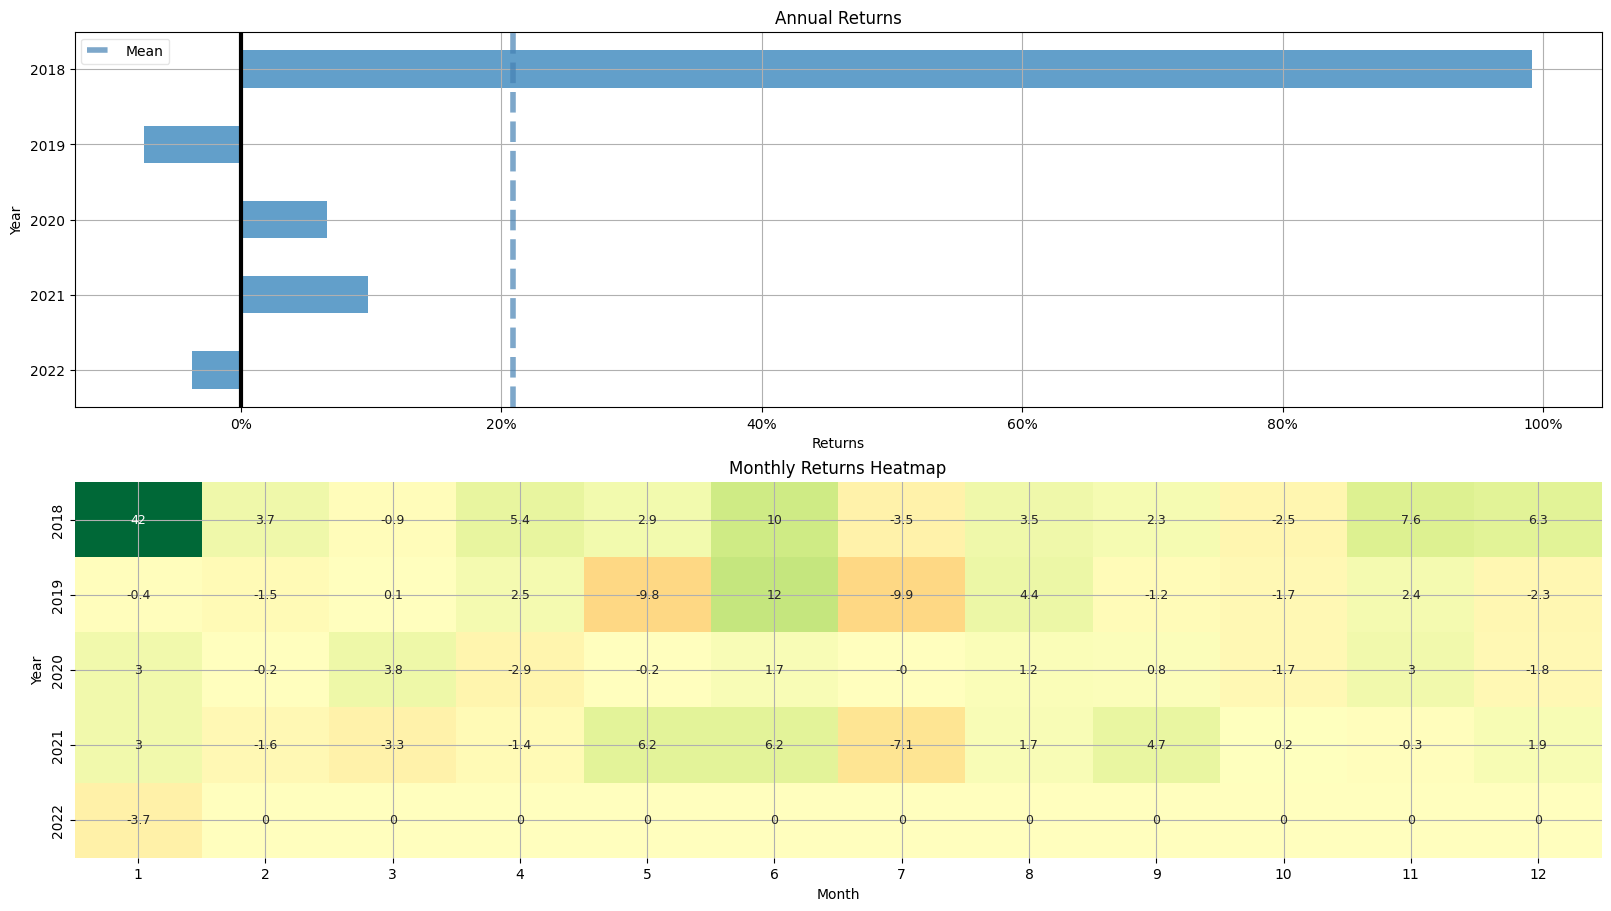

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plotting annual returns and returns heatmap

fig, ax = plt.subplots(nrows=2, figsize=(16, 9), constrained_layout=True)
axes = ax.flatten()

pf.plot_annual_returns(returns=returns, ax=axes[0])
axes[0].set_title('Annual Returns')
axes[0].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[1])
axes[1].set_title('Monthly Returns Heatmap')
axes[1].grid(True)

plt.show()

plt.savefig('Chart4_Perf_Analysis_2.png', dpi=300)